In [1]:
import sys
sys.path.append('D:\\Desktop\\Lipschitz_DSNN') 

In [2]:
import numpy as np
import torch
import os
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
# from torch.utils import tensorboard
import torch.nn as nn

from architectures.base_model import BaseModel
from architectures.simple_fc import SimpleFC
from layers.lipschitzlinear import LipschitzLinear
from projections.fc_projections import identity, bjorck_orthonormalize_fc
from utils import metrics, utilities, spline_utils
from dataloader.Function_1D import Function1D, generate_testing_set, slope_1_ae, slope_1_flat, cosines, threshold
from activations.linearspline import LinearSpline



In [3]:
### let's load the SimpleFCClassification model
from classification_LS import SimpleFCClassification # it works

In [4]:
## importing the trainer 
from trainer_class_LS_test import CustomDataset, Trainer_classification

In [5]:
### importing some utility functions
from utils_test_classification import plot_confusion_matrix, plot_losses_trained_model

Let's load the S shaped data again

In [6]:
### Area Classification Problem
import numpy as np

# Given function g (vectorized)
g = lambda x: 0.4 * np.sin(-5*x)

# Define the label function (vectorized)
def S_shape_label_fn(coordinate_2d):
    x1, x2 = coordinate_2d[:, 0], coordinate_2d[:, 1]
    return np.logical_and(np.abs(x1 - g(x2)) <= 0.3, np.abs(x2) < 0.8).astype(int)

# class 0 DPs: 5000 and # class 1 DPs: 5000


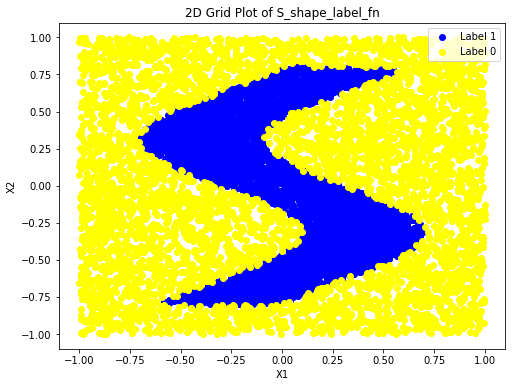

In [7]:
# Function to generate a balanced dataset
def generate_balanced_data(num_dp_per_class):
    x_data = []
    y_data = []
    num_class_0 = 0
    num_class_1 = 0
    
    while num_class_0 < num_dp_per_class or num_class_1 < num_dp_per_class:
        x_candidate = np.random.uniform(-1.0, 1.0, size=(1, 2))
        y_candidate = S_shape_label_fn(x_candidate)
        
        if y_candidate == 0 and num_class_0 < num_dp_per_class:
            x_data.append(x_candidate)
            y_data.append(y_candidate)
            num_class_0 += 1
        elif y_candidate == 1 and num_class_1 < num_dp_per_class:
            x_data.append(x_candidate)
            y_data.append(y_candidate)
            num_class_1 += 1

    x_data = np.vstack(x_data)
    y_data = np.concatenate(y_data)
    return x_data, y_data

# Generate balanced data
num_dp_per_class = 5000  # Number of data points per class
x_mat, y_mat = generate_balanced_data(num_dp_per_class)

# Count the number of data points for each class
num_zeros = np.count_nonzero(y_mat == 0)
num_ones = np.count_nonzero(y_mat == 1)
print(f"# class 0 DPs: {num_zeros} and # class 1 DPs: {num_ones}")

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_mat[y_mat == 1, 0], x_mat[y_mat == 1, 1], color='blue', label='Label 1')
plt.scatter(x_mat[y_mat == 0, 0], x_mat[y_mat == 0, 1], color='yellow', label='Label 0')
plt.title('2D Grid Plot of S_shape_label_fn')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
# plt.grid(True)
plt.show()


In [8]:
### I would need this function later.
scale_factor=10
x_mat_new = scale_factor * x_mat
# Given function g (vectorized)
g2 = lambda x: 0.4*scale_factor * np.sin(-5*x/scale_factor)

# Define the label function (vectorized)
def S_shape_label_fn2(coordinate_2d):
    x1, x2 = coordinate_2d[:, 0], coordinate_2d[:, 1]
    return np.logical_and(np.abs(x1 - g2(x2)) <= 0.3*scale_factor, np.abs(x2) < 0.8*scale_factor).astype(int)

Code to evaluate the model I have made some changes here

In [9]:
### function to evaluate the trained model
def evaluate_model(trained_model_input, y_test_fn, dataset_size=100, noise_level=0.003, 
                    want_confusion_matrix=False,
                    print_preds=False, range_of_value=1):
    # Generate test dataset
    x_test = np.random.uniform(-range_of_value, range_of_value, size=(dataset_size, 2)) + noise_level * np.ones(shape=(dataset_size, 2))
    y_test = y_test_fn(x_test)
    #print(f"y_test is:"); print(y_test)

    # Convert to torch tensors
    x_test, y_test = torch.tensor(x_test), torch.tensor(y_test)

    # Make predictions
    with torch.no_grad():
        preds = trained_model_input(x_test)
        if print_preds:
            print("predictions are:")
            print(preds)

    # Calculate accuracy
    acc_test = (preds.squeeze().round() == y_test).float().mean()
    print(f"Test accuracy: {acc_test.item():.4f}")
    # Plot confusion matrix
    if want_confusion_matrix:
        plot_confusion_matrix(preds.squeeze().round(), y_test, classes=["0", "1"])
    
    return x_test, y_test, preds

Defining the model parameters

In [10]:
### model parameters
network_param = {'bias': True,
    'layer_sizes': [2, 8,8, 1], 
    'projection': 'no_projection' , ### Let's change it from 'orthonormalize' to 'no_projection'
    'weight_initialization': 'He_uniform'}

additional_network_params= {'activation_type': 'linearspline', ### this is of interest
    'groupsort_groupsize': 5,
    'prelu_init': -1,
    'lipschitz_constrained': True,### this is of interest
    'spline_init': 'relu',### this is of interest
    'spline_range': 0.9,### this is of interest [-1,1]
    'spline_scaling_coeff': True,### this is of interest
    'spline_size': 19,#101,###
    'lmbda': 1e-07}### this is of interest [e-10,e2]

for_optimizer = {'lr_spline_coeffs': 5e-05, # This is learning rate for linear splines
    'lr_spline_scaling_coeffs': 0.0005,
    'lr_weights': 0.002}# original 0.002

training_options = {'batch_size': 64*5,  
    'epochs': 100,
    'nbr_models': 1,
    'num_workers': 1,
    'validation_split':0.2}

### for model without bjorck orthonormalisation
config_train_classification = { 'activation_fn_params':additional_network_params,
                            'exp_name' : "S shaped classification",
                            'net_params' : network_param,
                            'optimizer' : for_optimizer,
                            'training_options' : training_options
}

## for model with bjorck orthonormalisation
### creating a new configuration for training the model with bjork orthonormalisation
import copy
config_train_classification_bjork= copy.deepcopy(config_train_classification)
config_train_classification_bjork['net_params']['projection']='orthonormalize'
### lot orthonormalisation
config_train_classification_LOT = copy.deepcopy(config_train_classification)
config_train_classification_LOT['net_params']['projection'] = 'orthonormalize'
config_train_classification_LOT['net_params']['LOT'] = {'LOT_iters': 10}


Without bjorck orthonormalisation and with the original X matrix (no scaling, we shall see it next)

no orthonormalisation. projection= identity
Model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=8, bias=True)
    (3): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (4): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
in Train set: # class 0 DPs: 4039 and # class 1 DPs: 3961
in val set: # class 0 DPs: 961 and # class 1 DPs: 1039


100%|██████████| 25/25 [00:01<00:00, 18.82it/s]


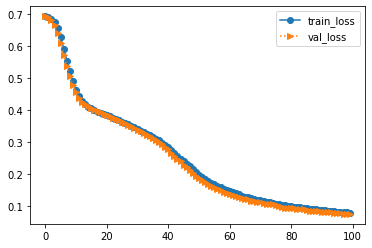

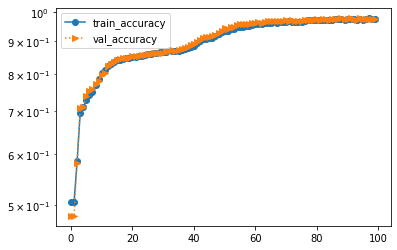

Final training accuracy is: 0.975
Final validation accuracy is: 0.976
---------Trained model's (with no orthonormalisation and trained on nearly balanced TS) performance on the test data-----------
test number: 1
Test accuracy: 0.9600


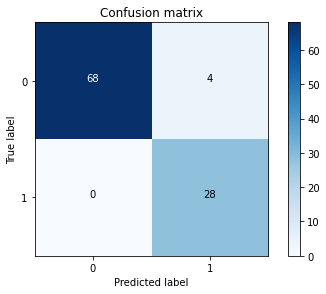

test number: 2
Test accuracy: 0.9600


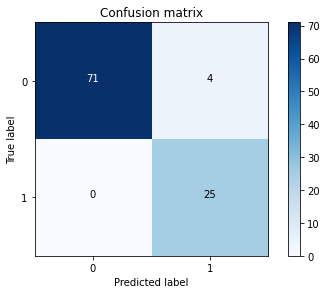

test number: 3
Test accuracy: 0.9600


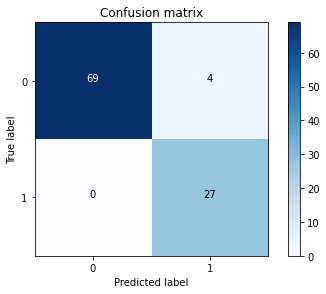

test number: 4
Test accuracy: 0.9600


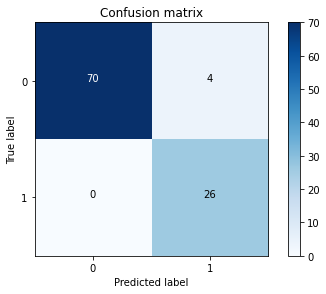

test number: 5
Test accuracy: 0.9700


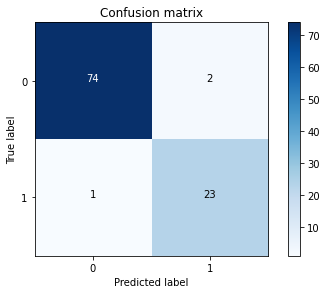

test number: 6
Test accuracy: 1.0000


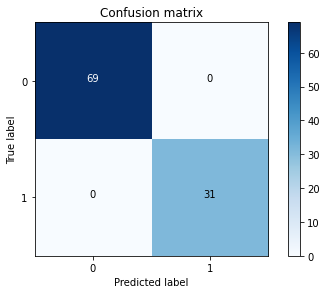

In [11]:
# Define the criterion
criterion = nn.BCELoss()

# Define the model
ds_simple_fc_model_1= SimpleFCClassification(
    network_parameters=config_train_classification['net_params'], 
    **additional_network_params)
ds_simple_fc_model_1 = ds_simple_fc_model_1.to('cpu')
print("Model is:")
print(ds_simple_fc_model_1)

# Instantiate the Trainer
trainer_no_bjork = Trainer_classification(model=ds_simple_fc_model_1,
                                    xdata=x_mat,
                                    ydata=y_mat,
                                    criterion=criterion,
                                    config=config_train_classification,
                                    seed=12,
                                    device='cpu',
                                    print_after_epoch=1000
                                    )

# Train the model
trainer_no_bjork.train()

### plotting loss curves
plot_losses_trained_model(trainer_no_bjork)

### evaluating the trained model's performance on the test dataset
print("---------Trained model's (with no orthonormalisation and trained on nearly balanced TS) performance on the test data-----------")
for i in range(0,6):
    print(f"test number: {i+1}")
    evaluate_model(ds_simple_fc_model_1, S_shape_label_fn, 
                                    dataset_size=100,
                    want_confusion_matrix=True, print_preds=False)

Without bjorck orthonormalisation and with scaled  X matrix

  8%|▊         | 2/25 [00:00<00:01, 15.90it/s]

no orthonormalisation. projection= identity
Model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=8, bias=True)
    (3): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (4): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
in Train set: # class 0 DPs: 4039 and # class 1 DPs: 3961
in val set: # class 0 DPs: 961 and # class 1 DPs: 1039


100%|██████████| 25/25 [00:00<00:00, 31.96it/s]


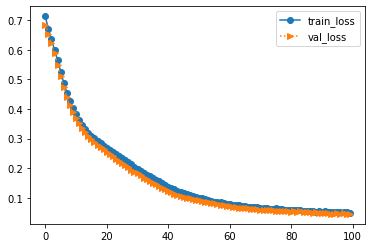

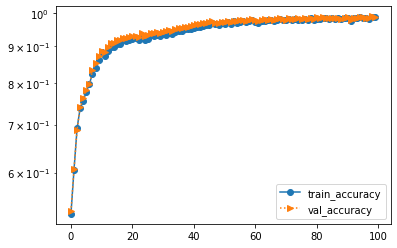

Final training accuracy is: 0.987
Final validation accuracy is: 0.988
---------Trained model's (with no orthonormalisation and trained on nearly balanced TS) performance on the test data-----------
test number: 1
Test accuracy: 0.9500


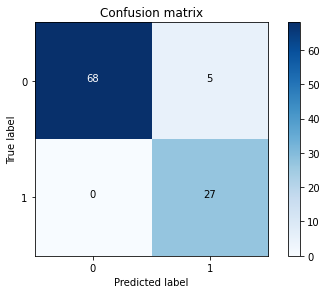

test number: 2
Test accuracy: 0.9700


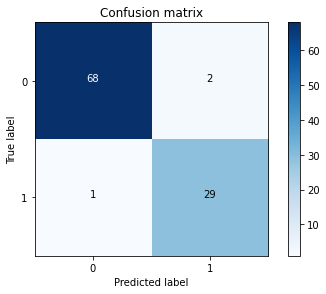

test number: 3
Test accuracy: 1.0000


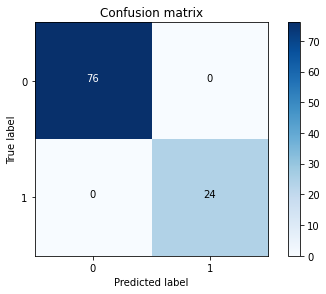

test number: 4
Test accuracy: 1.0000


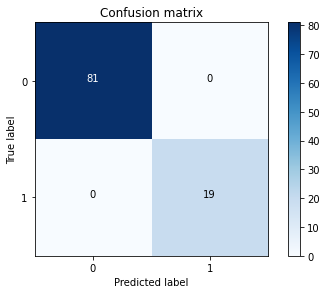

test number: 5
Test accuracy: 0.9800


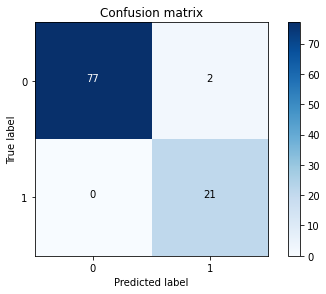

test number: 6
Test accuracy: 1.0000


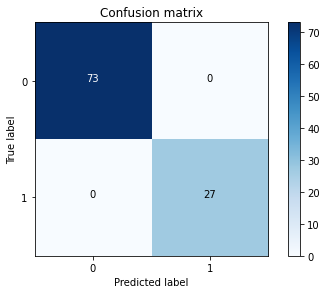

In [12]:
# Define the criterion
criterion = nn.BCELoss()

# Define the model
ds_simple_fc_model2= SimpleFCClassification(
    network_parameters=config_train_classification['net_params'], 
    **additional_network_params)
ds_simple_fc_model2 = ds_simple_fc_model2.to('cpu')
print("Model is:")
print(ds_simple_fc_model2)

# Instantiate the Trainer
trainer_no_bjork = Trainer_classification(model=ds_simple_fc_model2,
                                    xdata=x_mat_new,
                                    ydata=y_mat,
                                    criterion=criterion,
                                    config=config_train_classification,
                                    seed=12,
                                    device='cpu',
                                    print_after_epoch=1000
                                    )

# Train the model
trainer_no_bjork.train()

### plotting loss curves
plot_losses_trained_model(trainer_no_bjork)

### evaluating the trained model's performance on the test dataset
print("---------Trained model's (with no orthonormalisation and trained on nearly balanced TS) performance on the test data-----------")
for i in range(0,6):
    print(f"test number: {i+1}")
    evaluate_model(ds_simple_fc_model2, S_shape_label_fn2, want_confusion_matrix=True
                , range_of_value=scale_factor)

Observation: when linear layers are not orthogonalised, There is not a drastic change if I scale the matrix 

 Let' s check with bjorck orthonormalisation 

With bjorck orthonormalisation and without X_scaled

  0%|          | 0/25 [00:00<?, ?it/s]

  8%|▊         | 2/25 [00:00<00:01, 13.47it/s]

Orthonormalisation will take place.
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=8, bias=True)
    (3): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (4): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
in Train set: # class 0 DPs: 4039 and # class 1 DPs: 3961
in val set: # class 0 DPs: 961 and # class 1 DPs: 1039


100%|██████████| 25/25 [00:02<00:00, 11.67it/s]


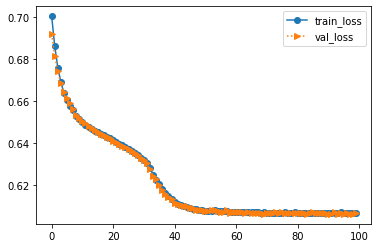

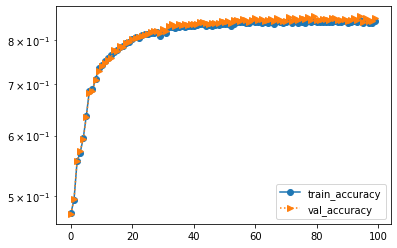

Final training accuracy is: 0.846
Final validation accuracy is: 0.855
--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------
test number: 1
Test accuracy: 0.8700


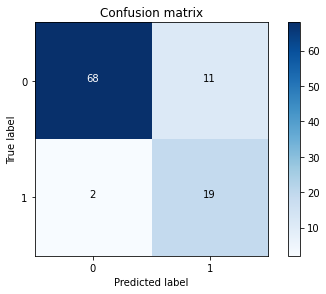

test number: 2
Test accuracy: 0.8600


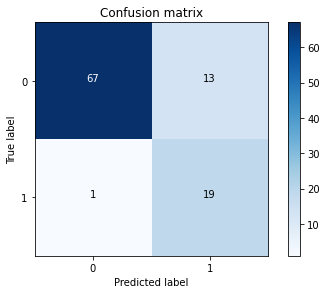

test number: 3
Test accuracy: 0.8500


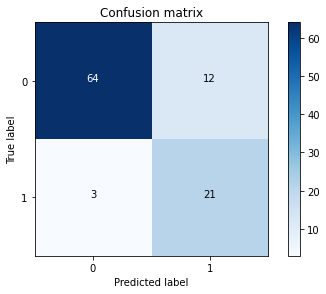

test number: 4
Test accuracy: 0.8000


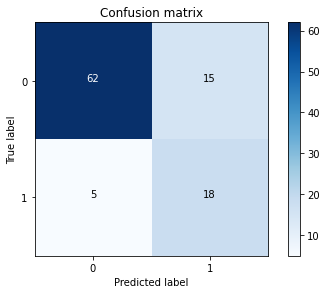

test number: 5
Test accuracy: 0.8600


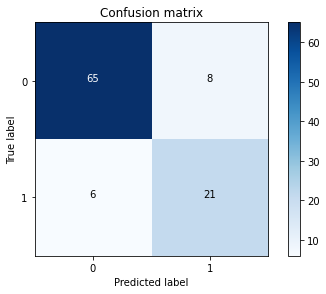

test number: 6
Test accuracy: 0.8700


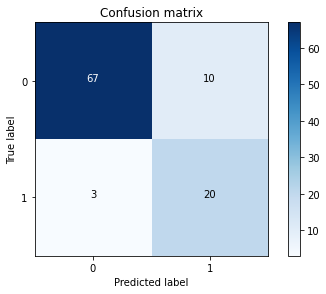

In [13]:
## criterion is: criterion
criterion= nn.BCELoss()

## model
## defining the model
ds_simple_fc_bjork_balanced_model1 = SimpleFCClassification(network_parameters=config_train_classification_bjork['net_params'],
                                                           **additional_network_params)
ds_simple_fc_bjork_balanced_model1 = ds_simple_fc_bjork_balanced_model1.to('cpu')
print("model is:"); print(ds_simple_fc_bjork_balanced_model1)

### instantiate the Trainer 
trainer_classification_bjork_balanced = Trainer_classification(model=ds_simple_fc_bjork_balanced_model1,
                                                        ###using a roughly balanced dataset
                                                        xdata=x_mat,
                                                        ydata=y_mat,
                                                        ###ROUGHLY BALANCED (because during splitting #class 0 DP could be not exactly = # class 1 DPs)
                                                        criterion=criterion,
                                                        config=config_train_classification_bjork,
                                                        seed=12,
                                                        device='cpu',
                                                        print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
                                                        )

### Let's train the model
trainer_classification_bjork_balanced.train() ### 

### plotting loss curves
plot_losses_trained_model(trainer_classification_bjork_balanced)

### evaluating the trained model's performance on the test dataset
print("--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------")
for i in range(0, 6):
    print(f"test number: {i+1}")
    evaluate_model(ds_simple_fc_bjork_balanced_model1, S_shape_label_fn, 
                    want_confusion_matrix=True, print_preds=False)

In [14]:
np.max(x_mat), np.max(y_mat)

(0.999799922312866, 1)

### Now let's see what happpens if I change the range of values (let's increase the range of our dataset and see)

In [15]:
# Plotting
# plt.figure(figsize=(8, 6))
# plt.scatter(x_mat_new[y_mat == 1, 0], x_mat_new[y_mat == 1, 1], color='blue', label='Label 1')
# plt.scatter(x_mat_new[y_mat == 0, 0], x_mat_new[y_mat == 0, 1], color='yellow', label='Label 0')
# plt.title('2D Grid Plot of S_shape_label_fn')
# plt.xlabel('X1') 
# plt.ylabel('X2')
# plt.legend()
# # plt.grid(True)
# plt.show()

With bjorck orthonormalisation and with X scaled = 10 * X_original

  0%|          | 0/25 [00:00<?, ?it/s]

Orthonormalisation will take place.
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=8, bias=True)
    (3): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (4): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
in Train set: # class 0 DPs: 4039 and # class 1 DPs: 3961
in val set: # class 0 DPs: 961 and # class 1 DPs: 1039


100%|██████████| 25/25 [00:02<00:00, 12.14it/s]


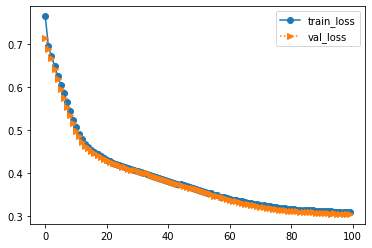

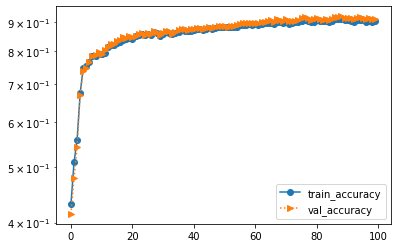

Final training accuracy is: 0.904
Final validation accuracy is: 0.911
--------Trained model's  (With orthogonal linear layer) performance on the test data, with X_scaled =  10 * X ------
 Test number is: 1
Test accuracy: 0.8500


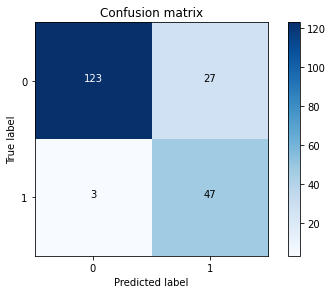

 Test number is: 2
Test accuracy: 0.8850


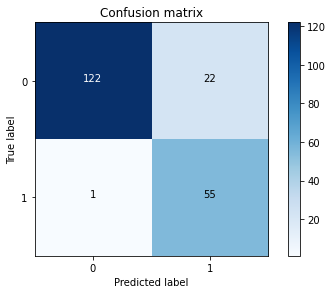

 Test number is: 3
Test accuracy: 0.8800


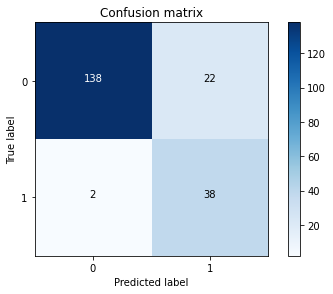

 Test number is: 4
Test accuracy: 0.9050


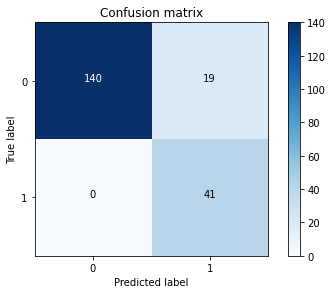

 Test number is: 5
Test accuracy: 0.9000


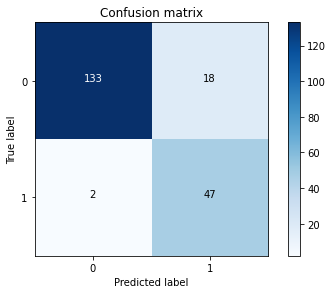

 Test number is: 6
Test accuracy: 0.8550


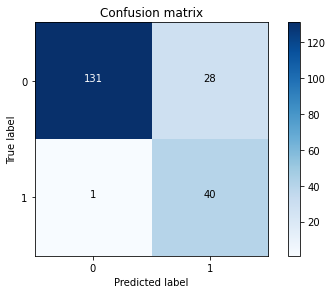

In [16]:
## criterion is: criterion
criterion= nn.BCELoss()

## model
## defining the model
ds_simple_fc_bjork_balanced_model2 = SimpleFCClassification(
    network_parameters=config_train_classification_bjork['net_params'],
    **additional_network_params)
ds_simple_fc_bjork_balanced_model2 = ds_simple_fc_bjork_balanced_model2.to('cpu')
print("model is:"); print(ds_simple_fc_bjork_balanced_model2)

### instantiate the Trainer 
trainer_classification_bjork_balanced = Trainer_classification(model=ds_simple_fc_bjork_balanced_model2,
                                                        ###using a roughly balanced dataset
                                                        xdata=x_mat_new,
                                                        ydata=y_mat,
                                                        ###ROUGHLY BALANCED (because during splitting #class 0 DP could be not exactly = # class 1 DPs)
                                                        criterion=criterion,
                                                        config=config_train_classification_bjork,
                                                        seed=12,
                                                        device='cpu',
                                                        print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
                                                        )

### Let's train the model
trainer_classification_bjork_balanced.train() ### 

### plotting loss curves
plot_losses_trained_model(trainer_classification_bjork_balanced)

print("--------Trained model's  (With orthogonal linear layer) performance on the test data, with X_scaled =  10 * X ------")

for i in range(0,6):
    print(f" Test number is: {i +1}")
    x_test, y_test, preds=evaluate_model(ds_simple_fc_bjork_balanced_model2, S_shape_label_fn2, 
                                        dataset_size=200,
                        want_confusion_matrix=True, print_preds=False, range_of_value=10)

* Training and validation accuracy has improved a lot with X scaled.

--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------
Test accuracy: 0.8583


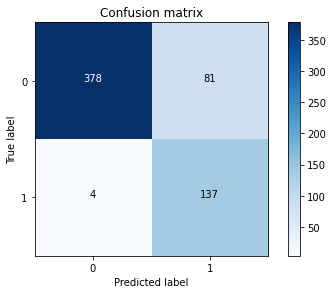

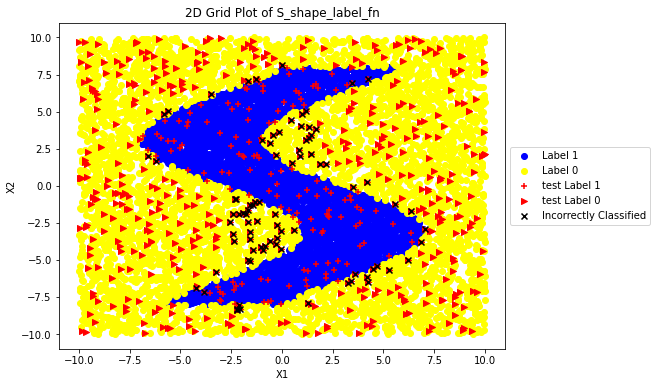

In [17]:
### evaluating the trained model's performance on the test dataset
print("--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------")
x_test, y_test, preds=evaluate_model(ds_simple_fc_bjork_balanced_model2, S_shape_label_fn2, 
                                    dataset_size=600,
                    want_confusion_matrix=True, print_preds=False, range_of_value=scale_factor)


#incorrect indices:
incorrect_indices = (preds.squeeze().round() != y_test).nonzero(as_tuple=True)[0].tolist()


# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_mat_new[y_mat == 1, 0], x_mat_new[y_mat == 1, 1], color='blue', label='Label 1')
plt.scatter(x_mat_new[y_mat == 0, 0], x_mat_new[y_mat == 0, 1], color='yellow', label='Label 0')
plt.scatter(x_test[y_test == 1, 0], x_test[y_test == 1,1], marker="+",color="red", label="test Label 1")
plt.scatter(x_test[y_test == 0, 0], x_test[y_test == 0,1], marker=">",color="red", label="test Label 0")
# Plot incorrectly classified points
plt.scatter(x_test[incorrect_indices, 0], x_test[incorrect_indices, 1], marker='x', color='black', label='Incorrectly Classified')
plt.title('2D Grid Plot of S_shape_label_fn')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend() 

# Position the legend outside the plot on the left middle side
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.show()

What if I scale values by 100? (X_scaled = 100* X_original)

In [18]:
### I would need this function later.
scale_factor=100
x_mat_new_2 = scale_factor * x_mat
# Given function g (vectorized)
g2 = lambda x: 0.4*scale_factor * np.sin(-5*x/scale_factor)

# Define the label function (vectorized)
def S_shape_label_fn2(coordinate_2d):
    x1, x2 = coordinate_2d[:, 0], coordinate_2d[:, 1]
    return np.logical_and(np.abs(x1 - g2(x2)) <= 0.3*scale_factor, np.abs(x2) < 0.8*scale_factor).astype(int)

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:00<00:02,  8.36it/s]

Orthonormalisation will take place.
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=8, bias=True)
    (3): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (4): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
in Train set: # class 0 DPs: 4039 and # class 1 DPs: 3961
in val set: # class 0 DPs: 961 and # class 1 DPs: 1039


100%|██████████| 25/25 [00:01<00:00, 12.50it/s]


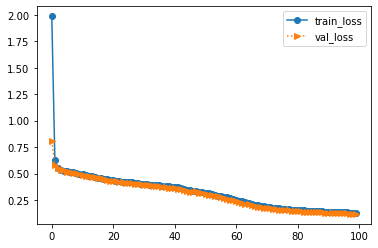

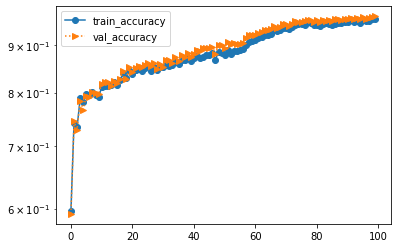

Final training accuracy is: 0.960
Final validation accuracy is: 0.967
 Test number is: 1
--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------
Test accuracy: 0.9433


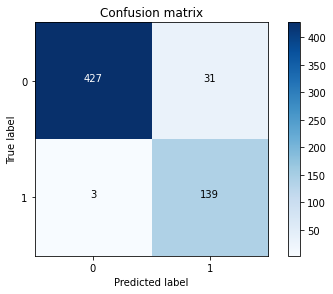

 Test number is: 2
--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------
Test accuracy: 0.9600


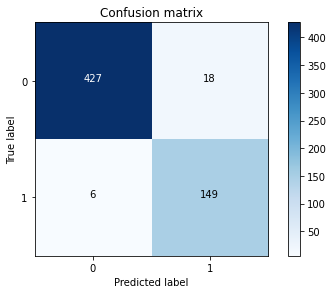

 Test number is: 3
--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------
Test accuracy: 0.9483


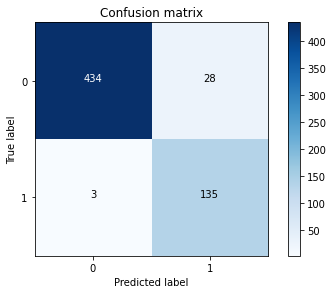

 Test number is: 4
--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------
Test accuracy: 0.9567


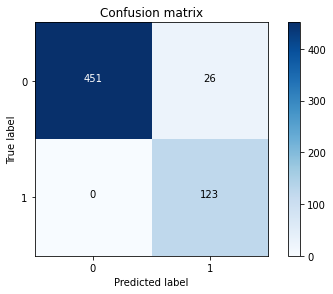

 Test number is: 5
--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------
Test accuracy: 0.9583


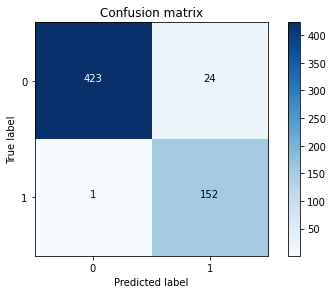

 Test number is: 6
--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------
Test accuracy: 0.9433


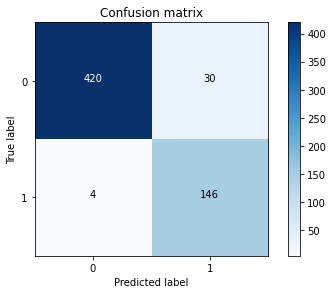

In [19]:
## criterion is: criterion
criterion= nn.BCELoss()

## model
## defining the model
ds_simple_fc_bjork_balanced_model3 = SimpleFCClassification(
    network_parameters=config_train_classification_bjork['net_params'],
    **additional_network_params)
ds_simple_fc_bjork_balanced_model3 = ds_simple_fc_bjork_balanced_model3.to('cpu')
print("model is:"); print(ds_simple_fc_bjork_balanced_model2)

### instantiate the Trainer 
trainer_classification_bjork_balanced = Trainer_classification(model=ds_simple_fc_bjork_balanced_model3,
                                                        ###using a roughly balanced dataset
                                                        xdata=x_mat_new_2,
                                                        ydata=y_mat,
                                                        ###ROUGHLY BALANCED (because during splitting #class 0 DP could be not exactly = # class 1 DPs)
                                                        criterion=criterion,
                                                        config=config_train_classification_bjork,
                                                        seed=12,
                                                        device='cpu',
                                                        print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
                                                        )

### Let's train the model
trainer_classification_bjork_balanced.train() ### 

### plotting loss curves
plot_losses_trained_model(trainer_classification_bjork_balanced)


for i in range(0,6):
    print(f" Test number is: {i +1}")
    print("--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------")
    x_test, y_test, preds=evaluate_model(ds_simple_fc_bjork_balanced_model3, S_shape_label_fn2, 
                                        dataset_size=600,
                        want_confusion_matrix=True, print_preds=False, range_of_value=scale_factor)

--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------
Test accuracy: 0.9550


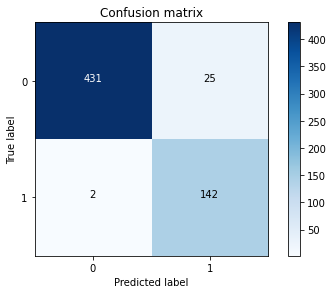

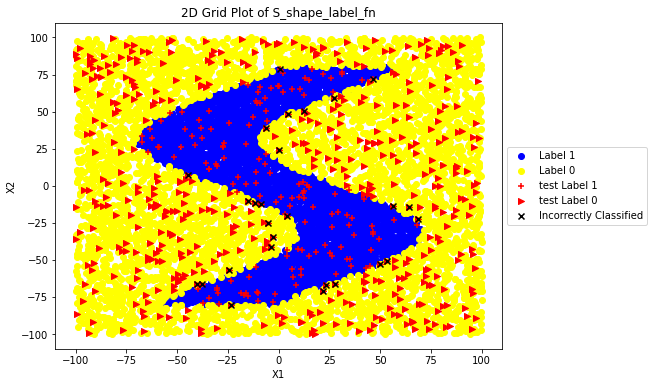

In [20]:
### evaluating the trained model's performance on the test dataset
print("--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------")
x_test, y_test, preds=evaluate_model(ds_simple_fc_bjork_balanced_model3, S_shape_label_fn2, 
                                    dataset_size=600,
                    want_confusion_matrix=True, print_preds=False, range_of_value=scale_factor)


#incorrect indices:
incorrect_indices2 = (preds.squeeze().round() != y_test).nonzero(as_tuple=True)[0].tolist()


# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_mat_new_2[y_mat == 1, 0], x_mat_new_2[y_mat == 1, 1], color='blue', label='Label 1')
plt.scatter(x_mat_new_2[y_mat == 0, 0], x_mat_new_2[y_mat == 0, 1], color='yellow', label='Label 0')
plt.scatter(x_test[y_test == 1, 0], x_test[y_test == 1,1], marker="+",color="red", label="test Label 1")
plt.scatter(x_test[y_test == 0, 0], x_test[y_test == 0,1], marker=">",color="red", label="test Label 0")
# Plot incorrectly classified points
plt.scatter(x_test[incorrect_indices2, 0], x_test[incorrect_indices2, 1], marker='x', color='black', label='Incorrectly Classified')
plt.title('2D Grid Plot of S_shape_label_fn')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend() 

# Position the legend outside the plot on the left middle side
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.show()

### OBSERVATION:

1. performance for X $\in$ [0,1] < [0,10] $\leq$ [0,100]

Tasks to do:

1. Check the performance at different resolution.  (partially done. Now I wanna kinda scale the values and then see)
2. Check the performance of the model for different orthogonalisation model.

### Investigating the last layer's weight matrix for all models above

Without bjorck orthogonalisation

In [21]:
# Temporarily set requires_grad to False
wt_no_scaling = ds_simple_fc_model_1.layers[-2].weight.detach().clone()
wt_scaling = ds_simple_fc_model2.layers[-2].weight.detach().clone()

# Print the detached weights
print("wt simple, original X: ",wt_no_scaling)
print("wt simple, Scaled X: ",wt_scaling)

wt simple, original X:  tensor([[-2.2981,  5.0048, -2.2703,  5.1756,  5.2527,  5.7392,  2.0374,  1.3282]])
wt simple, Scaled X:  tensor([[-0.7647,  3.4302, -0.8309, -0.9723,  0.9282,  0.9163, -1.8930, -2.3087]])


With bjorck orthogonalisation

In [22]:
# Temporarily set requires_grad to False
wt_orth_no_scaling = ds_simple_fc_bjork_balanced_model1.layers[-2].weight.detach().clone()
wt_orth_scaling = ds_simple_fc_bjork_balanced_model2.layers[-2].weight.detach().clone()
wt_orth_scaling2 = ds_simple_fc_bjork_balanced_model3.layers[-2].weight.detach().clone()
# Print the detached weights
print("wt with orthogonalised layer , trained on just X: ",wt_orth_no_scaling)
print("wt with orthogonalised layer , trained on scaled X (x 10): ",wt_orth_scaling)
print("wt with orthogonalised layer 2 , trained on scaled X (x 100): ",wt_orth_scaling2)

wt with orthogonalised layer , trained on just X:  tensor([[-0.0540,  0.0006, -0.2657, -0.2688,  0.2139,  0.0009, -0.0025,  0.0004]])
wt with orthogonalised layer , trained on scaled X (x 10):  tensor([[-0.0830,  0.1560,  0.0828,  0.0597,  0.1588, -0.3930, -0.0783,  0.0169]])
wt with orthogonalised layer 2 , trained on scaled X (x 100):  tensor([[ 0.2362, -0.1264, -0.1032,  0.4539, -0.2715,  0.1962, -0.1943,  0.0041]])
